## Embeddings

In [1]:
import re, gensim, logging, multiprocessing, datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense

In [2]:
# paths to change
output_path = './salida'

# congig
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = multiprocessing.cpu_count()-1

__process methods__

In [3]:
def expand_contractions(document: str) -> str:
    """
    Replace all abbreviations with their corresponding expansion
    """
    document = re.sub(r"'cause", "because", document)
    document = re.sub(r"o'clock", "of the clock", document)
    document = re.sub(r"won\'t", "will not", document)
    document = re.sub(r"can\'t", "can not", document)
    document = re.sub(r"n\'t", " not", document)
    document = re.sub(r"\'re", " are", document)
    document = re.sub(r"\'s", " is", document)
    document = re.sub(r"\'d", " would", document)
    document = re.sub(r"\'ll", " will", document)
    document = re.sub(r"\'t", " not", document)
    document = re.sub(r"\'ve", " have", document)
    document = re.sub(r"\'m", " am", document)
    return document

In [4]:
def replace_numbers(document: str) -> str:
    """
    Replace number appearances with 'number'
    """
    # Case 1: Combination of numbers and letters (Eg. 2nd -> NUM)
    document = re.sub('[a-zA-Z]+[0-9]+[a-zA-Z]+', 'number', document)
    document = re.sub('[0-9]+[a-zA-Z]+|[a-zA-Z]+[0-9]+', 'number', document)
    # Case 2: Decimal numbers (Eg. 2.1 -> NUM)
    document = re.sub('[0-9]+\.+[0-9]+', 'number', document)
    # Case 3: Numbers between spaces (Eg. 220 888 -> NUM)
    document = re.sub('([0-9]+\s)*[0-9]+', 'number', document)
    # Case 4: One or more of the previous cases (Eg. NUM NUM -> NUM)
    document = re.sub('((NUM)+\s)*(NUM)+', 'number', document)
    return document

In [5]:
def preprocessing(document: str) -> list:
    """
    iterate over all words in document identifing the word and frecuency
    remove all the problematic characters over the word
    and return a dictionary with the word as the key and the frecuency as the value
    """
    document = document.lower()
    document = expand_contractions(document)
    document = replace_numbers(document)
    document = re.sub('[^A-Za-z0-9]+', ' ', document)
    document = document.split()
    return document

In [6]:
def get_sentences() -> pd.DataFrame:
    """
    read and process document
    """
    dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
    df = dataset['train'].to_pandas()
    data = pd.DataFrame()
    data['text'] = df.text
    data['processed'] = df.text.apply(preprocessing)
    data['hatespeech'] = df.hate_speech_score.apply(lambda x: 1 if x > 0 else 0)
    return data

In [7]:
def train_model(size: int, window: int, data: list, epochs: int) -> gensim.models.Word2Vec:
    """
    Train the word2vec embedding
    """
    model = gensim.models.Word2Vec(sentences=data, 
                                   vector_size=size, 
                                   window=window, 
                                   workers=workers, 
                                   min_count=3, 
                                   alpha=0.025, 
                                   min_alpha=0.0007)
    model.build_vocab(data, progress_per=100000)
    model.train(data, total_examples=len(data), epochs=epochs)
    return model

## Create embedding

In [8]:
sentences = get_sentences()
sentences.sample(10)

2022-07-27 12:59:21,663 : WARNING : Using custom data configuration ucberkeley-dlab--measuring-hate-speech-1d47093687320b66
2022-07-27 12:59:21,707 : WARNING : Reusing dataset parquet (C:\Users\Usuario\.cache\huggingface\datasets\ucberkeley-dlab___parquet\ucberkeley-dlab--measuring-hate-speech-1d47093687320b66\0.0.0\7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

,text,processed,hatespeech
72690,@BiggieChesse12 Yeah fr these hoes be petty as...,"[number, yeah, fr, these, hoes, be, petty, asf...",1
66207,The woman Muslim she's looking so cute ... mus...,"[the, woman, muslim, she, is, looking, so, cut...",0
100184,Every slant in #LosAngeles should be deported....,"[every, slant, in, losangeles, should, be, dep...",1
5301,🔴#Israel ⚠🔼🔽 Where are human rights and intern...,"[israel, where, are, human, rights, and, inter...",0
16593,Is arameo.(sp?) The true language of the Jews ...,"[is, arameo, sp, the, true, language, of, the,...",0
104853,"Hey ,muslim dickhead !!!!!!!! Why don;t you go...","[hey, muslim, dickhead, why, don, t, you, go, ...",1
25298,"it's so true, dude. this is completely natural...","[it, is, so, true, dude, this, is, completely,...",1
60009,@Duke_Doberman Then yah tell em you're a gay l...,"[duke, doberman, then, yah, tell, em, you, are...",1
89797,"Since none of you #cuck wanna have fun, I'm go...","[since, none, of, you, cuck, wanna, have, fun,...",1
67621,@TahirNasser @DesiDocMI Tahir you make an exce...,"[tahirnasser, desidocmi, tahir, you, make, an,...",0


In [9]:
#Train embedding
embedding = train_model(size=150, window=3, data=list(sentences['processed']), epochs=20)

2022-07-27 12:59:29,370 : INFO : collecting all words and their counts
2022-07-27 12:59:29,371 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-27 12:59:29,397 : INFO : PROGRESS: at sentence #10000, processed 260239 words, keeping 19201 word types
2022-07-27 12:59:29,433 : INFO : PROGRESS: at sentence #20000, processed 519498 words, keeping 28373 word types
2022-07-27 12:59:29,463 : INFO : PROGRESS: at sentence #30000, processed 784049 words, keeping 32838 word types
2022-07-27 12:59:29,492 : INFO : PROGRESS: at sentence #40000, processed 1042524 words, keeping 35810 word types
2022-07-27 12:59:29,521 : INFO : PROGRESS: at sentence #50000, processed 1307330 words, keeping 38072 word types
2022-07-27 12:59:29,551 : INFO : PROGRESS: at sentence #60000, processed 1565718 words, keeping 39324 word types
2022-07-27 12:59:29,580 : INFO : PROGRESS: at sentence #70000, processed 1824124 words, keeping 40644 word types
2022-07-27 12:59:29,616 : INFO : PROGRESS:

In [10]:
#Save model
embedding.save(f'{output_path}/embedding.model')

2022-07-27 13:00:08,890 : INFO : Word2Vec lifecycle event {'fname_or_handle': './salida/embedding.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-07-27T13:00:08.890117', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
2022-07-27 13:00:08,891 : INFO : not storing attribute cum_table
2022-07-27 13:00:08,965 : INFO : saved ./salida/embedding.model


In [11]:
#Load models
embedding = gensim.models.Word2Vec.load(f'{output_path}/embedding.model')

2022-07-27 13:00:08,982 : INFO : loading Word2Vec object from ./salida/embedding.model
2022-07-27 13:00:09,100 : INFO : loading wv recursively from ./salida/embedding.model.wv.* with mmap=None
2022-07-27 13:00:09,101 : INFO : setting ignored attribute cum_table to None
2022-07-27 13:00:09,325 : INFO : Word2Vec lifecycle event {'fname': './salida/embedding.model', 'datetime': '2022-07-27T13:00:09.325652', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}


In [12]:
embedding.wv.most_similar(positive=["california", "texas", "florida"], topn=15)

[('ebloa', 0.44950732588768005),
 ('exile', 0.4405592381954193),
 ('virginia', 0.43502095341682434),
 ('punjab', 0.4240919053554535),
 ('northeast', 0.4114379286766052),
 ('minnesota', 0.4103951156139374),
 ('cuntry', 0.4065544903278351),
 ('mexico', 0.40480172634124756),
 ('angeles', 0.4021584093570709),
 ('sc', 0.40105655789375305),
 ('phillipines', 0.40040645003318787),
 ('prison', 0.4002951681613922),
 ('shalom', 0.3977826237678528),
 ('philippines', 0.3966759145259857),
 ('northern', 0.3960830867290497)]

## train the ML model

In [13]:
def sentence_to_embedding(sentence: str) -> np.array:
    """
    Returns the element-wise mean of the embeddings that represent each word in a sentence
    """
    words = preprocessing(sentence)
    vector = np.zeros(embedding.layer1_size)
    counter = 0
    for word in words:
        try:
            vector += embedding.wv[word]
            counter += 1
        except:
            pass
    if counter > 0:
        vector = vector / counter
    return vector

In [14]:
y_sample = sentences['hatespeech'].astype(float)
X_sample = sentences['text'].astype(str)

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X_sample.values, 
                                                    y_sample.values, 
                                                    random_state=42,test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=42,test_size=0.125)

print('Number of rows in the total set: {}'.format(X_sample.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the validation set: {}'.format(X_validation.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 135556
Number of rows in the training set: 94888
Number of rows in the validation set: 13556
Number of rows in the test set: 27112


In [15]:
X_train = pd.DataFrame(X_train, columns=['data']).data.apply(sentence_to_embedding)
X_validation = pd.DataFrame(X_validation, columns=['data']).data.apply(sentence_to_embedding)
X_test = pd.DataFrame(X_test, columns=['data']).data.apply(sentence_to_embedding)

In [16]:
# Create the classification model
model = Sequential()
model.add(Dense(150, activation='relu'))
model.add(Dense(90, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(x=np.asarray(X_train.to_list()).astype('float32'),
                    y=y_train,
                    batch_size=32, 
                    epochs=50,
                    validation_data=(np.asarray(X_validation.to_list()).astype('float32'), y_validation),
                    shuffle=True)

Epoch 1/50
2966/2966 [==============================] - 4s 1ms/step - loss: 0.3354 - accuracy: 0.8405 - val_loss: 0.3049 - val_accuracy: 0.8539
Epoch 2/50
2966/2966 [==============================] - 4s 1ms/step - loss: 0.2974 - accuracy: 0.8584 - val_loss: 0.3025 - val_accuracy: 0.8565
Epoch 3/50
2966/2966 [==============================] - 4s 1ms/step - loss: 0.2789 - accuracy: 0.8687 - val_loss: 0.2825 - val_accuracy: 0.8705
Epoch 4/50
2966/2966 [==============================] - 4s 1ms/step - loss: 0.2625 - accuracy: 0.8776 - val_loss: 0.2784 - val_accuracy: 0.8715
Epoch 5/50
2966/2966 [==============================] - 3s 1ms/step - loss: 0.2457 - accuracy: 0.8869 - val_loss: 0.2733 - val_accuracy: 0.8771
Epoch 6/50
2966/2966 [==============================] - 4s 1ms/step - loss: 0.2307 - accuracy: 0.8942 - val_loss: 0.2609 - val_accuracy: 0.8837
Epoch 7/50
2966/2966 [==============================] - 4s 1ms/step - loss: 0.2156 - accuracy: 0.9029 - val_loss: 0.2582 - val_accuracy:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               22650     
                                                                 
 dense_1 (Dense)             (None, 90)                13590     
                                                                 
 dense_2 (Dense)             (None, 45)                4095      
                                                                 
 dense_3 (Dense)             (None, 15)                690       
                                                                 
 dense_4 (Dense)             (None, 1)                 16        
                                                                 
Total params: 41,041
Trainable params: 41,041
Non-trainable params: 0
_________________________________________________________________


In [20]:
accr = model.evaluate(np.asarray(X_test.to_list()).astype('float32'), y_test)
accr

848/848 [==============================] - 1s 2ms/step - loss: 0.3779 - accuracy: 0.9427


[0.3778544068336487, 0.9427191019058228]

In [21]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.378
  Accuracy: 0.943


In [22]:
model.save('salida/embedding_model')

INFO:tensorflow:Assets written to: salida/embedding_model\assets


2022-07-27 13:06:04,869 : INFO : Assets written to: salida/embedding_model\assets


In [23]:
def prediction(text: str, model: bin) -> str:
    emddng = np.asarray([sentence_to_embedding(text).tolist()]).astype('float32')
    pred = model.predict(emddng, verbose=1)
    result = 'Hate Speech' if pred > 0.5 else 'Not Hate Speech'
    print(pred, result)
    return result

In [24]:
loaded_model = load_model('salida/embedding_model')

In [25]:
prediction('i hate you', loaded_model)
prediction('i love you', loaded_model)
prediction('i owe you', loaded_model)
prediction('You got bitch slapped with your own source', loaded_model)
prediction('get away from here stupid bitch', loaded_model)

1/1 [==============================] - 0s 281ms/step
[[1.]] Hate Speech
1/1 [==============================] - 0s 44ms/step
[[1.4975794e-16]] Not Hate Speech
1/1 [==============================] - 0s 45ms/step
[[0.02784728]] Not Hate Speech
1/1 [==============================] - 0s 43ms/step
[[0.9999998]] Hate Speech
1/1 [==============================] - 0s 46ms/step
[[0.00929866]] Not Hate Speech


'Not Hate Speech'

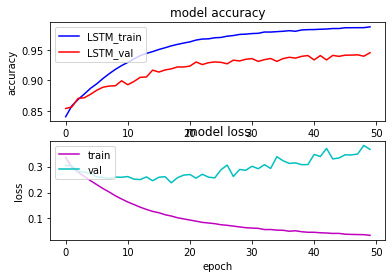

In [26]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

## GloVe2word2vec - Embeddings

In [27]:
glove_filename = './datos/glove.6B.100d.txt'

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_filename, word2vec_output_file)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10204\3203449831.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_filename, word2vec_output_file)
2022-07-27 13:06:08,240 : INFO : loading projection weights from ./datos/glove.6B.100d.txt
2022-07-27 13:07:46,708 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from ./datos/glove.6B.100d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-07-27T13:07:46.708210', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}
2022-07-27 13:07:46,710 : INFO : converting 400000 vectors from ./datos/glove.6B.100d.txt to ./datos/glove.6B.100d.txt.word2vec
2022-07-27 13:07:47,334 : INFO : storing 400000x100 projection weights into ./datos/glove.

(400000, 100)

In [28]:
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
embedding = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

2022-07-27 13:08:51,687 : INFO : loading projection weights from ./datos/glove.6B.100d.txt.word2vec
2022-07-27 13:10:25,662 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from ./datos/glove.6B.100d.txt.word2vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-07-27T13:10:25.662279', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}


In [29]:
def glove_sentence_to_embedding(sentence: str) -> np.array:
    """
    Returns the element-wise mean of the embeddings that represent each word in a sentence
    """
    words = preprocessing(sentence)
    vector = np.zeros(embedding.vector_size)
    counter = 0
    for word in words:
        try:
            vector += embedding.get_vector(word)
            counter += 1
        except Exception as e:
            pass
    if counter > 0:
        vector = vector / counter
    return vector

In [30]:
y_sample = sentences['hatespeech'].astype(float)
X_sample = sentences['text'].astype(str)

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X_sample.values, 
                                                    y_sample.values, 
                                                    random_state=42,test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=42,test_size=0.125)

print('Number of rows in the total set: {}'.format(X_sample.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the validation set: {}'.format(X_validation.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 135556
Number of rows in the training set: 94888
Number of rows in the validation set: 13556
Number of rows in the test set: 27112


In [31]:
X_train = pd.DataFrame(X_train, columns=['data']).data.apply(glove_sentence_to_embedding)
X_validation = pd.DataFrame(X_validation, columns=['data']).data.apply(glove_sentence_to_embedding)
X_test = pd.DataFrame(X_test, columns=['data']).data.apply(glove_sentence_to_embedding)

In [32]:
# Create the classification model
glove_model = Sequential()
glove_model.add(Dense(100, activation='relu'))
glove_model.add(Dense(75, activation='relu'))
glove_model.add(Dense(50, activation='relu'))
glove_model.add(Dense(25, activation='relu'))
glove_model.add(Dense(1, activation='sigmoid'))

In [33]:
# Compile the model
glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Train the model
glove_history = glove_model.fit(x=np.asarray(X_train.to_list()).astype('float32'),
                    y=y_train, 
                    batch_size=32, 
                    epochs=50,
                    validation_data=(np.asarray(X_validation.to_list()).astype('float32'), y_validation),
                    shuffle=True)

Epoch 1/50
2966/2966 [==============================] - 9s 3ms/step - loss: 0.3852 - accuracy: 0.8220 - val_loss: 0.3529 - val_accuracy: 0.8339
Epoch 2/50
2966/2966 [==============================] - 7s 2ms/step - loss: 0.3388 - accuracy: 0.8371 - val_loss: 0.3286 - val_accuracy: 0.8400
Epoch 3/50
2966/2966 [==============================] - 7s 2ms/step - loss: 0.3258 - accuracy: 0.8433 - val_loss: 0.3343 - val_accuracy: 0.8368
Epoch 4/50
2966/2966 [==============================] - 7s 2ms/step - loss: 0.3151 - accuracy: 0.8466 - val_loss: 0.3362 - val_accuracy: 0.8409
Epoch 5/50
2966/2966 [==============================] - 6s 2ms/step - loss: 0.3061 - accuracy: 0.8509 - val_loss: 0.3278 - val_accuracy: 0.8491
Epoch 6/50
2966/2966 [==============================] - 7s 2ms/step - loss: 0.2980 - accuracy: 0.8567 - val_loss: 0.3169 - val_accuracy: 0.8503
Epoch 7/50
2966/2966 [==============================] - 7s 2ms/step - loss: 0.2908 - accuracy: 0.8591 - val_loss: 0.3224 - val_accuracy:

In [35]:
glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 75)                7575      
                                                                 
 dense_7 (Dense)             (None, 50)                3800      
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 22,776
Trainable params: 22,776
Non-trainable params: 0
_________________________________________________________________


In [36]:
accr = glove_model.evaluate(np.asarray(X_test.to_list()).astype('float32'), y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

848/848 [==============================] - 1s 2ms/step - loss: 0.3311 - accuracy: 0.9115
Test set
  Loss: 0.331
  Accuracy: 0.912


In [37]:
def glove_prediction(text: str, model: bin) -> str:
    emddng = np.asarray([glove_sentence_to_embedding(text).tolist()]).astype('float32')
    pred = model.predict(emddng, verbose=1)
    result = 'Hate Speech' if pred > 0.5 else 'Not Hate Speech'
    print(text, ' | ', result, ' | ', pred)
    return result

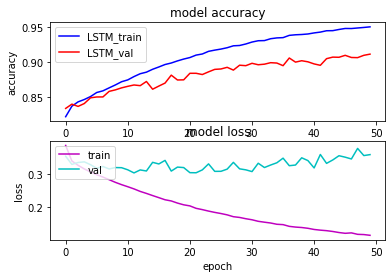

In [38]:
s, (at, al) = plt.subplots(2,1)
at.plot(glove_history.history['accuracy'], c= 'b')
at.plot(glove_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(glove_history.history['loss'], c='m')
al.plot(glove_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [39]:
glove_prediction('i hate you', glove_model)
glove_prediction('i love you', glove_model)
glove_prediction('i owe you', glove_model)
glove_prediction('You got bitch slapped with your own source', glove_model)
glove_prediction('stupid bitch', glove_model)
glove_prediction('you will die right now', glove_model)

1/1 [==============================] - 0s 146ms/step
i hate you  |  Hate Speech  |  [[1.]]
1/1 [==============================] - 0s 34ms/step
i love you  |  Not Hate Speech  |  [[9.426472e-09]]
1/1 [==============================] - 0s 44ms/step
i owe you  |  Not Hate Speech  |  [[0.46290556]]
1/1 [==============================] - 0s 35ms/step
You got bitch slapped with your own source  |  Hate Speech  |  [[0.98613983]]
1/1 [==============================] - 0s 44ms/step
stupid bitch  |  Not Hate Speech  |  [[0.1486929]]
1/1 [==============================] - 0s 80ms/step
you will die right now  |  Hate Speech  |  [[0.9950314]]


'Hate Speech'

In [40]:
glove_model.save('salida/embedding_glove')

INFO:tensorflow:Assets written to: salida/embedding_glove\assets


2022-07-27 13:17:14,489 : INFO : Assets written to: salida/embedding_glove\assets


In [41]:
loaded_model = load_model('salida/embedding_glove')

In [42]:
glove_prediction('i hate you', loaded_model)
glove_prediction('i love you', loaded_model)
glove_prediction('i owe you', loaded_model)
glove_prediction('You got bitch slapped with your own source', loaded_model)
glove_prediction('get away from here stupid bitch', loaded_model)
glove_prediction('you will die sooner or later', loaded_model)

1/1 [==============================] - 0s 174ms/step
i hate you  |  Hate Speech  |  [[1.]]
1/1 [==============================] - 0s 52ms/step
i love you  |  Not Hate Speech  |  [[9.426472e-09]]
1/1 [==============================] - 0s 56ms/step
i owe you  |  Not Hate Speech  |  [[0.46290556]]
1/1 [==============================] - 0s 46ms/step
You got bitch slapped with your own source  |  Hate Speech  |  [[0.98613983]]
1/1 [==============================] - 0s 45ms/step
get away from here stupid bitch  |  Not Hate Speech  |  [[0.09979708]]
1/1 [==============================] - 0s 47ms/step
you will die sooner or later  |  Hate Speech  |  [[1.]]


'Hate Speech'